# Model Optimization in PyTorch: A Penalized Regression Case

In this lesson, we wll revisit regularization and linear regression—this time through the lens of `PyTorch`. Along the way, you will be introduced to some of the core capabilities of this powerful library for model building and optimization.

The goal of bringing `PyTorch` into the picture early in the course is to set the stage for what is coming soon: neural networks! So keep an open mind and enjoy the journey—we are laying the groundwork for more exciting topics ahead.

By the end of this tutorial, you should be able to:

- Recall what regularization is, why it is important, and how to apply it using `scikit-learn`.
- Implement a linear regression model using `PyTorch`.
- Optimize model parameters via stochastic gradient descent.

## 1. Revisiting Regularized Regression

Let us briefly review the theory and intuition behind regularized regression. Regularization is a fundamental technique in machine learning used to prevent overfitting, especially when dealing with high-dimensional data or data suffering from multicollinearity.

Recall that a linear regression model is a simple parametric model where each observed value, $y_i$, is approximated by a linear combination of an intercept and $p$ slopes (weights), each multiplying an input feature $x_{ij}$. The error in the prediction is denoted by $\epsilon_i$. This can be written as:

$$
y_i = \alpha + \sum_{j=1}^p x_{ij} \cdot \beta_j + \epsilon_i,
$$

where $\alpha$ and $\beta_j$ are the coefficients of the linear regression model, normally called the intercept and the slopes, respectively.

How are these coefficients estimated? By **minimizing** a cost function, $J(\alpha, \beta_j)$, which in this case is the residual sum of squares between the predicted and observed values:

$$
J(\alpha, \beta_j) = \sum_{i}(y_i - \alpha - \sum_{j=1}^p x_{ij} \beta_j)^2
$$

However, when the model is too complex, it may fit the noise in the training data, resulting in poor generalization to new data. Regularization addresses this issue by adding a penalty term to the cost function:

$$
J(\alpha, \beta_j) \rightarrow J(\alpha, \beta_j) + \lambda R(\beta_j)
$$

You can think of this as a constraint—in fact, regularization is a type of constrained optimization—that discourages overly complex models by shrinking the magnitude of the coefficients.

Depending on the form of the added term $R(\beta_j)$, there are several types of regularization:

- **Ridge Regression (L2 penalty):** Adds a penalty proportional to the square of the magnitude of the coefficients.

  $$
  R(\beta_j) = \sum_{j}\beta_j^2
  $$

- **Lasso Regression (L1 penalty):** Adds a penalty proportional to the absolute value of the coefficients, which can drive some coefficients exactly to zero, resulting in sparse models.

  $$
  R(\beta_j) = \sum_{j}|\beta_j|
  $$

- **ElasticNet:** Combines both L1 and L2 penalties, controlled by a mixing parameter $\lambda_{\text{mixing}}$.

  $$
  R(\beta_j) = \lambda_{\text{mixing}} \sum_{j}|\beta_j| + (1 - \lambda_{\text{mixing}}) \sum_{j}\beta_j^2
  $$

The predictions depend on the value of the regularization parameter $\lambda$, which controls the strength of the penalty. This value is typically chosen through cross-validation.

Let us now revisit how to implement these regularized models in `scikit-learn`. For that, we will use the diabetes dataset.

In [24]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import matplotlib.pylab as plt
import seaborn as sns

X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

**Please answer: Why are we scaling the features here?**

In `scikit-learn` it was very easy to use this kind of regularized regression models. For example, for Ridge with two different $\lambda$'s:

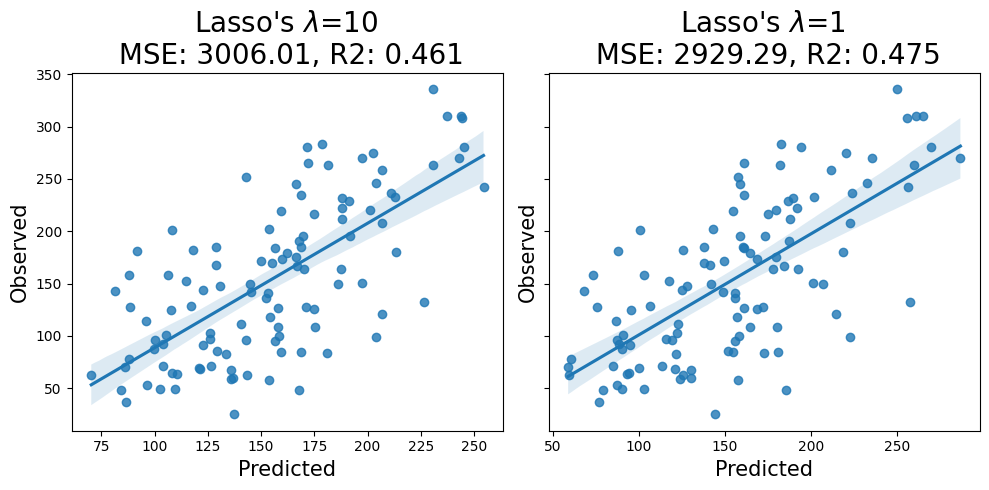

In [25]:
from sklearn.linear_model import Lasso

fig, axs  = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

for ax, lam, estim in zip(axs, 
                      ["10", "1"], 
                      [Lasso(alpha=10), Lasso(alpha=1)]):
    estim.fit(X_train, y_train)
    y_pred = estim.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    sns.regplot(x=y_pred, y=y_test, ax=ax)
    ax.set_title(r"Lasso's $\lambda$" + f"={lam} \n MSE: {mse:.2f}, R2: {r2:.3f}", size=20)
    ax.set_xlabel("Predicted", size=15)
    ax.set_ylabel("Observed", size=15)
plt.tight_layout()

The predictions depend on the value of the regularization parameter $\lambda$. Choosing an appropriate value for $\lambda$ is crucial for achieving good generalization performance.

Typically, the optimal $\lambda$ is selected through cross-validation. In the code below, we use `RidgeCV`, `LassoCV`, and `ElasticNetCV`, which automatically perform cross-validation to find the best value of $\lambda$ based on predictive performance.

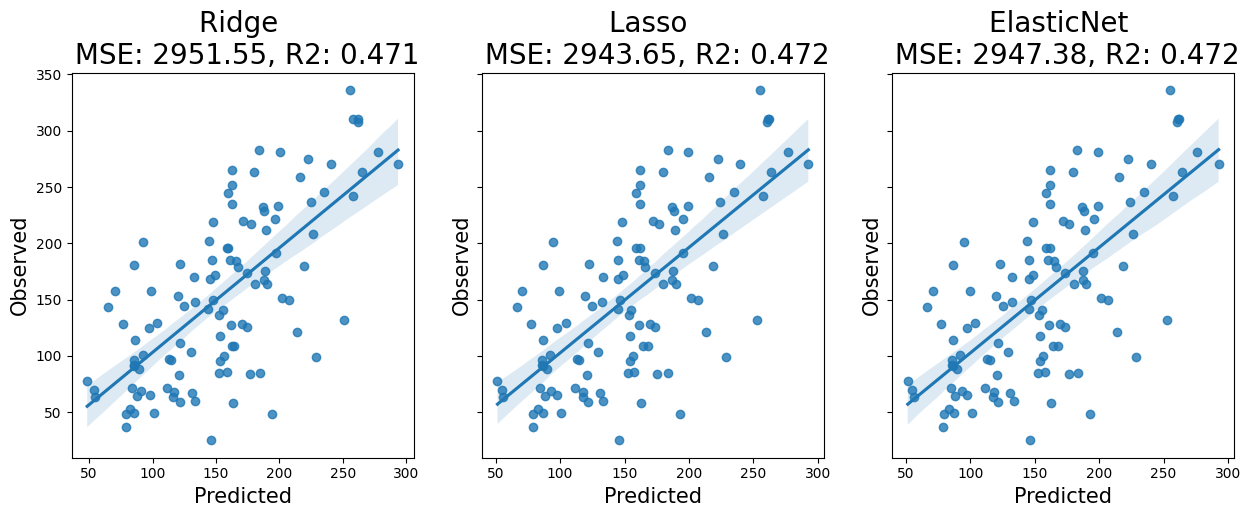

In [26]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

alphas = np.logspace(-4, 2, 100)

fig, axs  = plt.subplots(ncols=3, figsize=(15,5), sharey=True)

for ax, estim, name in zip(axs, 
                           [RidgeCV(), LassoCV(), ElasticNetCV()],
                           ["Ridge", "Lasso", "ElasticNet"]
                          ):
    
    estim.set_params(alphas=alphas)
    estim.fit(X_train, y_train)
    
    y_pred = estim.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    sns.regplot(x=y_pred, y=y_test, ax=ax)
    ax.set_title(f"{name} \n MSE: {mse:.2f}, R2: {r2:.3f}", size=20)
    ax.set_xlabel("Predicted", size=15)
    ax.set_ylabel("Observed", size=15)


And just to finish, remember what $\lambda$ does to the model coefficients:

Text(0, 0.5, '$\\beta$')

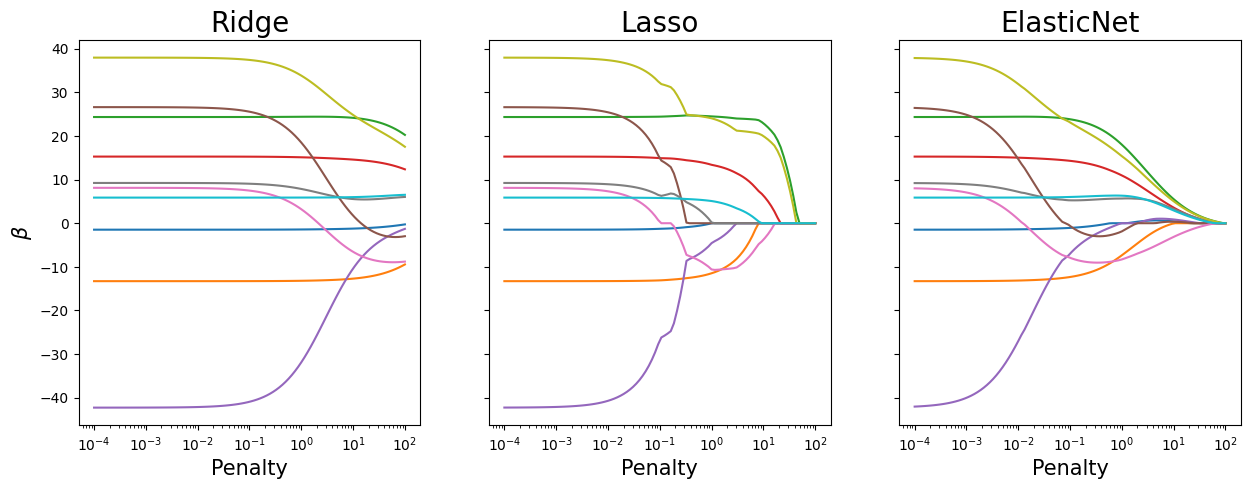

In [27]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

alphas = np.logspace(-4, 2, 100)

fig, axs  = plt.subplots(ncols=3, figsize=(15,5), sharey=True)

for ax, estim, name in zip(axs, 
                           [Ridge(), Lasso(), ElasticNet()],
                           ["Ridge", "Lasso", "ElasticNet"]
                          ):
    weights = []
    for alpha in alphas:
        estim.set_params(alpha=alpha)
        estim.fit(X_train, y_train)
        weights.append(estim.coef_)

    ax.plot(alphas, np.column_stack(weights).T)
    ax.set_xscale("log")
    ax.set_xlabel("Penalty", size=15)
    ax.set_title(name, size=20)
axs[0].set_ylabel(r"$\beta$", size=15)

As you can see, ridge regression tends to shrink coefficients smoothly, Lasso sets some coefficients exactly to zero, and ElasticNet provides a compromise between the two.

## 2 - Linear Regression in `PyTorch`

Now that we have revisited linear regression and regularization, let us implement both using `PyTorch`. This will not only reinforce what you already know, but also help you become familiar with using PyTorch for model building and optimization.

Remember again the linear regression model:

$$
y_i = \alpha + \sum_{j=1}^p x_{ij} \cdot \beta_j + \epsilon_i,
$$


In [29]:
# Import library
import torch

Let's define our weights and intercept with some random values.

In [33]:
torch.manual_seed(1234); # set seed for reproducibility of results
w = torch.randn(X_train.shape[1], dtype=torch.float64)
b = torch.randn(1, dtype=torch.float64)

print(w)
print(b)

tensor([ 0.0461,  0.4024, -1.0115,  0.2167, -0.6123,  0.5036,  0.2310,  0.6931,
        -0.2669,  2.1785], dtype=torch.float64)
tensor([0.1021], dtype=torch.float64)


And we can make predictions using the above model:

In [36]:
y_pred = X_test.matmul(w) + b

AttributeError: 'numpy.ndarray' object has no attribute 'matmul'

Obviously, we need to convert our numpy arrays to tensor for this to work:

In [40]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

TypeError: expected np.ndarray (got Tensor)

In [42]:
y_pred = X_test.matmul(w) + b

Text(0.5, 1.0, 'R2:-4.258, MSE:29335.727')

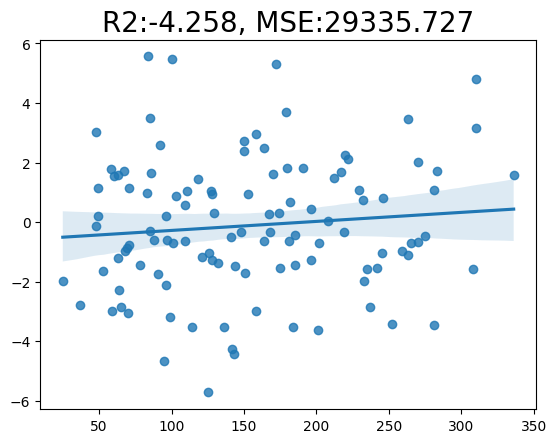

In [43]:
# Plot the predictions
r2 = r2_score(y_test.numpy(), y_pred.numpy())
mse = mean_squared_error(y_test.numpy(), y_pred.numpy())

sns.regplot(x=y_test.numpy(), y=y_pred.numpy())
plt.title(f"R2:{r2:.3f}, MSE:{mse:.3f}", size=20)

Obviously, the predictions are not good at this point, because we simply initialized the intercept and slopes to arbitrary values. What we need is to **learn** these parameters from the data.

As you have already seen in a previous course, in regression we typically estimate the parameters $\beta$ using the Ordinary Least Squares (OLS) method, which finds the values that minimize the mean squared error cost function. This leads to the closed-form solution:

$$
\beta = (X^T X)^{-1}X^T y
$$

However, in many situations, it is not possible or practical to minimize the loss function analytically. In such cases, we turn to **numerical optimization methods**. One of the most commonly used techniques is **Stochastic Gradient Descent (SGD)** and its variants (we will explore some of them later in the course).

We will not revisit the full mathematical details of SGD here — you have already encountered them in DS3025 — but in essence, SGD minimizes the cost function $J$ **iteratively and one observation at a time**, by updating (or "learning") the model parameters — the $\beta_j$ in the case of linear regression — using the following rule:

$$
\beta_j \leftarrow \beta_j - \gamma \, \frac{\partial J}{\partial \beta_j}
$$

Here, $\gamma$ is the **learning rate**, a hyperparameter that determines how much the parameters are adjusted in response to the gradient of the loss function at each step.



Let's see how to implement this in pytorch!

R2 test: 0.47084906342901933
MSE train: 2848.5762785742586


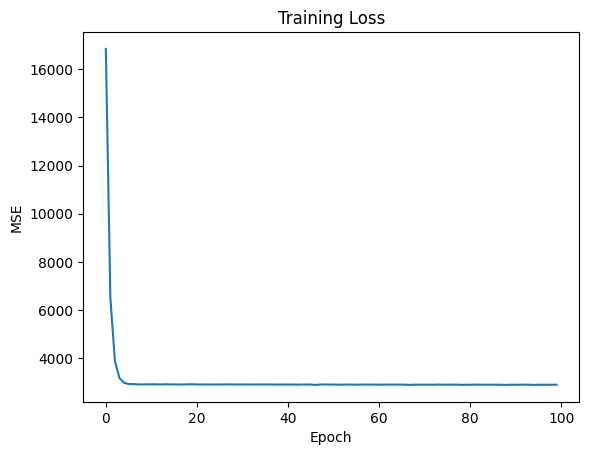

In [93]:
torch.manual_seed(1234); # set seed for reproducibility of results

# Initialize weights to some random value for the training
w = torch.randn(X_train.shape[1], dtype=X_train.dtype)
b = torch.randn(1, dtype=X_train.dtype)

# Set the learning parameter value
lr = 0.001

# The number of epochs
n_epochs = 100

epoch_costs = []
for epoch in range(n_epochs):
    
    perm = torch.randperm(X_train.size(0))
    X_epoch = X_train[perm]
    y_epoch = y_train[perm]
    
    total_cost = 0
    for x, y in zip(X_epoch, y_epoch):
        y_pred = b + x.matmul(w)
        cost = (y - y_pred) ** 2  # single sample cost

        # Gradients
        epsilon = y - y_pred
        grad_b = -2 * epsilon
        grad_w = -2 * x * epsilon

        # Update parameters
        w -= lr * grad_w
        b -= lr * grad_b
        
        total_cost += cost.item()
    epoch_costs.append(total_cost / len(y_train))
        
# Plot training loss
plt.plot(epoch_costs)
#plt.xscale("log")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")


# Predictions
y_test_pred = b + X_test.matmul(w)
y_train_pred = b + X_train.matmul(w)

print("R2 test:", r2_score(y_test.numpy(), y_test_pred.numpy()))
print("MSE train:", mean_squared_error(y_train.numpy(), y_train_pred.numpy()))

Let's compare this to the analytical result using OLS:

In [94]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()

linReg.fit(X_train.numpy(), y_train.numpy())

print("R2 test:", r2_score(y_test.numpy(), linReg.predict(X_test.numpy())))
print(mean_squared_error(y_train.numpy(), linReg.predict(X_train.numpy())))

R2 test: 0.46937607855967356
2839.196944775885


In [95]:
print((linReg.coef_, w.numpy()))
b, linReg.intercept_

(array([ -1.48196593, -13.28772015,  24.34895329,  15.27781458,
       -42.28622801,  26.61847343,   8.11421225,   9.23231855,
        37.9702308 ,   5.8727192 ]), array([ -1.44467531, -13.0680578 ,  24.98826114,  14.81608696,
       -20.01547411,   9.23030248,  -2.57240421,   6.20609486,
        29.54357686,   5.96387843]))


(tensor([151.5410], dtype=torch.float64), 151.4712990936556)

So pretty close!

But this raises a fair question: **Do we really need to compute the gradients analytically in order to implement this?**

What happens when our model becomes more complex than a simple linear regression?

Fortunately, `PyTorch` takes care of this for us — it can compute gradients automatically using its built-in **autograd** system.

This means that, as long as we define our model and loss function using PyTorch operations, the library can automatically compute all the required gradients for us, regardless of how complex the model is. **This is one of the core features that makes PyTorch so powerful for building and training neural networks.**

Let's see it in action:

R2 test: 0.47084906342901933
MSE train: 2848.5762785742586


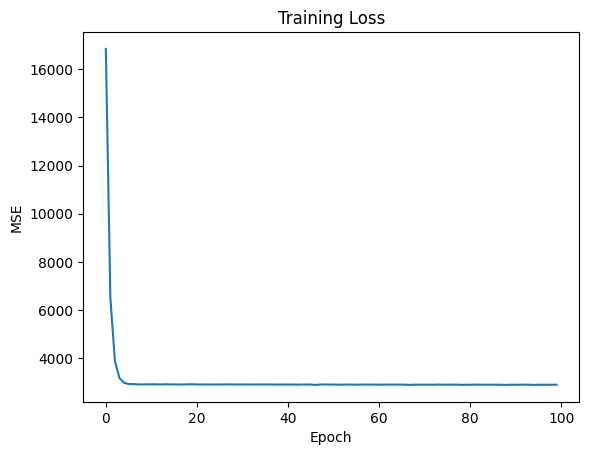

In [96]:
torch.manual_seed(1234); # set seed for reproducibility of results
w = torch.randn(X_train.shape[1], dtype=X_train.dtype, requires_grad=True)
b = torch.randn(1, dtype=X_train.dtype, requires_grad=True)

lr = 0.001

costs = []

n_epochs = 100
for epoch in range(n_epochs):
    
    perm = torch.randperm(X_train.size(0))
    X_epoch = X_train[perm]
    y_epoch = y_train[perm]
    
    epoch_cost = 0
    for x, y in zip(X_epoch, y_epoch):
        y_pred = b + x.matmul(w)
        cost = (y - y_pred) ** 2  # single sample cost
        
        # Backward pass
        cost.backward()
    
        # Update parameters using gradient and zero out gradients
        with torch.no_grad():
            w -= lr * w.grad
            b -= lr * b.grad
            w.grad.zero_()
            b.grad.zero_()
        
        epoch_cost += cost.item()

    costs.append(epoch_cost / len(X_epoch))  # avg cost per epoch


# Plot training loss
plt.plot(costs)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")


# Predictions
y_test_pred = b + X_test.matmul(w)
y_train_pred = b + X_train.matmul(w)

print("R2 test:", r2_score(y_test.numpy(), y_test_pred.detach().numpy())) # Detach is because we have requires_grad=True
print("MSE train:", mean_squared_error(y_train.numpy(), y_train_pred.detach().numpy())) # Detach is because we have requires_grad=True

Nice!! Exactly the same as before. Fantastic!

Let us now highlight the key elements we have introduced that are specific to `PyTorch` and its automatic differentiation system:

- **`requires_grad`**: This attribute specifies whether a tensor should track operations for gradient computation. If set to `True`, `PyTorch` will construct the computational graph for that tensor and compute gradients during backpropagation.

- **`.backward()`**: This method performs backpropagation, computing the gradients of the loss with respect to all tensors that have `requires_grad=True`. It is typically called on a scalar loss tensor.

- **`torch.no_grad()`**: This context manager disables gradient tracking. It is essential when manually updating parameters (e.g., during gradient descent) to prevent `PyTorch` from including the update operations in the computational graph.

- **`.grad`**: This attribute stores the accumulated gradients of a tensor after `.backward()` is called. These gradients are used to update the parameters.

- **`.grad.zero_()`**: Since `PyTorch` accumulates gradients by default (rather than overwriting them), this method is used to explicitly reset the gradients to zero before the next backward pass.


Neural networks will make use of all these elements, so you already have the essential building blocks needed for more complex models, such as neural networks!

## 3-Adding penalization (Ridge)

In this case, adding Ridge regularization is as simple as including the penalization term in the cost function:

```python
cost = (y - y_pred) ** 2 + (alpha / X_train.shape[0]) * w.pow(2).sum()
```

Note that we divide the regularization term by the number of training samples. This ensures that the contribution of the penalty remains consistent with the standard Ridge regression implementation and matches the behavior of `SGDRegressor` in `scikit-learn`, which applies this scaling internally.


Using numerical Ridge, R2 test: 0.4710101143837281
Using numerical Ridge, MSE train: 2849.9171731124657


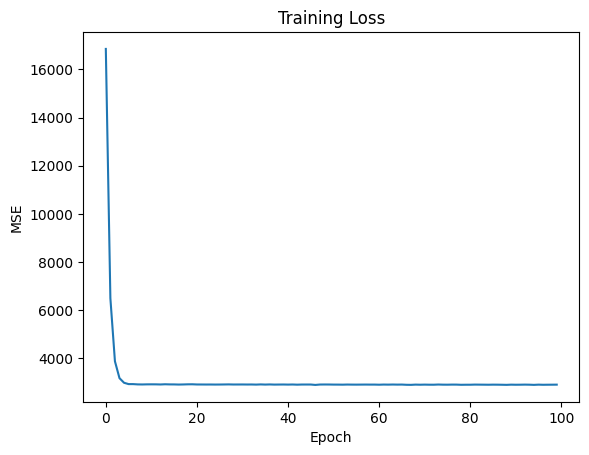

In [110]:
# Penalty term
alpha = 1 

torch.manual_seed(1234); # set seed for reproducibility of results
w = torch.randn(X_train.shape[1], dtype=X_train.dtype, requires_grad=True)
b = torch.randn(1, dtype=X_train.dtype, requires_grad=True)

lr = 0.001

costs = []

n_epochs = 100
for epoch in range(n_epochs):
    
    perm = torch.randperm(X_train.size(0))
    X_epoch = X_train[perm]
    y_epoch = y_train[perm]
    
    epoch_cost = 0
    for x, y in zip(X_epoch, y_epoch):
        y_pred = b + x.matmul(w)
        cost = (y - y_pred) ** 2  + (alpha / X_train.shape[0]) * w.pow(2).sum() # Look at this new term now!
        
        # Backward pass
        cost.backward()
    
        # Update parameters using gradient and zero out gradients
        with torch.no_grad():
            w -= lr * w.grad
            b -= lr * b.grad
            w.grad.zero_()
            b.grad.zero_()
        
        epoch_cost += cost.item()

    costs.append(epoch_cost / len(X_epoch))  # avg cost per epoch


# Plot training loss
plt.plot(costs)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")


# Predictions
y_test_pred = b + X_test.matmul(w)
y_train_pred = b + X_train.matmul(w)

print("Using numerical Ridge, R2 test:", 
      r2_score(y_test.numpy(), y_test_pred.detach().numpy())) # Detach is because we have requires_grad=True
print("Using numerical Ridge, MSE train:", 
      mean_squared_error(y_train.numpy(), y_train_pred.detach().numpy())) # Detach is because we have requires_grad=True

Let's compare this with the analytical implementation:

In [100]:
ridge = Ridge(alpha=1)

ridge.fit(X_train.numpy(), y_train.numpy())
ridge.coef_

print("Using Analytical Ridge, R2 test:", r2_score(y_test.numpy(), ridge.predict(X_test.numpy())))

Using Analytical Ridge, R2 test: 0.47097474748760737


Again, pretty close! Oh yes! 

<div class="alert alert-info">

**NOTE**

Stochastic Gradient Descent is also available in `scikit-learn` through the estimators [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) (for regression tasks) and [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (for classification tasks). These models internally apply the same principles we implemented here, including regularization and per-sample parameter updates.

</div>


In [111]:
from sklearn.linear_model import SGDRegressor

ridge = SGDRegressor(alpha=1 / X_train.shape[0], learning_rate="constant", eta0=lr, max_iter=n_epochs, l1_ratio=0, penalty="l2", random_state=1234)

ridge.fit(X_train.numpy(), y_train.numpy())

print("Using numerical Ridge (Scikit-learn), R2 test:", r2_score(y_test.numpy(), ridge.predict(X_test.numpy())))
print("Using numerical Ridge (Scikit-learn) MSE train:", mean_squared_error(y_train, ridge.predict(X_train.numpy())))

Using numerical Ridge (Scikit-learn), R2 test: 0.4706979893155432
Using numerical Ridge (Scikit-learn) MSE train: 2867.335537584819


## 4 - Summary

In this lesson, we revisited regularized linear regression and implemented it from scratch using `PyTorch`.

- We reviewed **Ridge**, **Lasso**, and **ElasticNet**, and how regularization influences parameter estimation.
- We implemented **linear regression with stochastic gradient descent (SGD)**, introducing core `PyTorch` features such as `requires_grad`, `.backward()`, `.grad`, and `torch.no_grad()`.
- We extended the model to include **Ridge regression** by adding an L2 penalty term to the loss function.

This hands-on introduction provides a solid foundation for building more complex models, including neural networks, which rely on the same underlying principles of optimization and gradient-based learning.

## 📝 5 - Exercise – Implement Linear Regression Class à la `scikit-learn` API with `PyTorch`

Reuse and rearrange the code above to implement a simple linear regression model using `PyTorch`, following the structure of a `scikit-learn` estimator.

Your class should include:

- An `__init__` method to set the learning rate and number of epochs.
- A `fit` method to train the model using stochastic gradient descent.
- A `predict` method to make predictions on new data.

Train your model on the diabetes dataset and evaluate its performance using `r2_score` and `mean_squared_error` from `sklearn.metrics`.

In [112]:
# YOUR CODE